In [1]:
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import lapprox

%matplotlib inline

# Линейный акселерометр

In [2]:
semor_profiles = {}
segments = {}

## Ходьба

In [3]:
df = pd.read_csv("data/walk_linear_accelerometer.csv", sep=";")
df = df.applymap(lambda s: float(s.replace(",", ".")))

In [4]:
(df.loc[0, 'ax'] ** 2 + df.loc[0, 'ay'] ** 2 + df.loc[0, 'az'] ** 2) ** (1/2)

1.1347321005417974

In [5]:
df.loc[0, 'aT']

1.135

In [6]:
df.head()

,time,ax,ay,az,aT
0,0.005,-0.8077,0.0422,-0.7959,1.135
1,0.005,-0.5126,-0.0684,-1.2847,1.385
2,0.006,-0.0684,-0.0480,-1.0223,1.026
3,0.016,0.0886,0.0550,-0.5753,0.585
4,0.033,-0.1366,0.1344,-0.1943,0.273


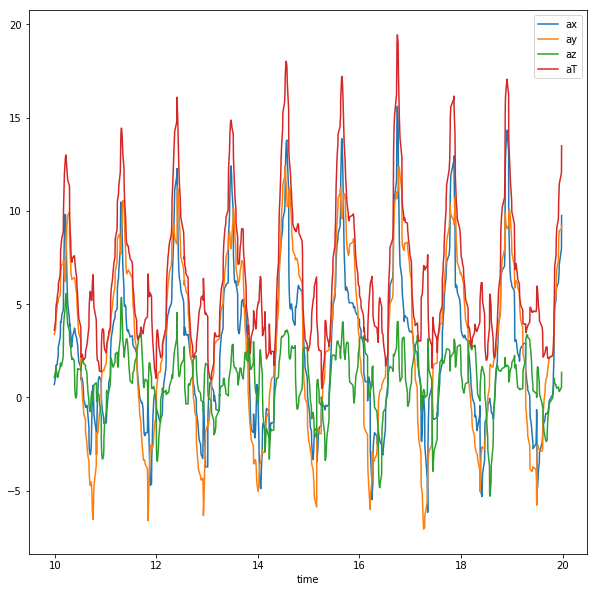

In [7]:
df[1000:2000].plot(x="time",figsize=(10, 10))

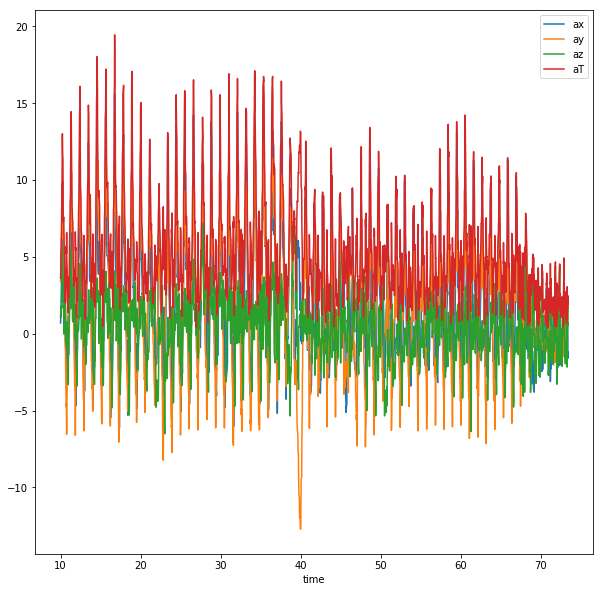

In [8]:
df[1000:].plot(x="time",figsize=(10, 10))

Повычленяем сегменты следующим образом

* Найдем максимумы тотального ускорения выше 9 и получим их временные метки

In [9]:
def extract_segment_bounds(df,
                           column_name,
                           max_threshold,
                           min_segment_size,
                           max_segment_size=10e8,
                           radius=1):
    # We take only those which have left and right neighbour
    indices = list(df.index)[1:-1]
    idx_local_maxima = np.where(lapprox.misc.local_extrema.find_local_extrema(df['aT'].values, radius))[0]
    idx_above_threshold = (idx for idx in idx_local_maxima if df.loc[idx, column_name] > max_threshold)
    idx_maxima = list(idx_above_threshold)
    idx_segments = [(idx_maxima[i], idx_maxima[i + 1]) for i in range(len(idx_maxima) - 1)]
    big_enough_segments = [pair for pair in idx_segments
                           if (pair[1] - pair[0] >= min_segment_size
                               and pair[1] - pair[0] <= max_segment_size)]
    return big_enough_segments   

In [10]:
# big_enough_segments = [pair for pair in idx_segments
#                        if pair[1] - pair[0] > 90]
big_enough_segments = extract_segment_bounds(df, 'aT', 8, 90)

In [11]:
segments['walk'] = [df.loc[first:second, 'aT'].values for first, second in big_enough_segments]

In [12]:
semor_profiles['walk'], s = lapprox.segments.smooth.cubic_smooth(segments['walk'], None)

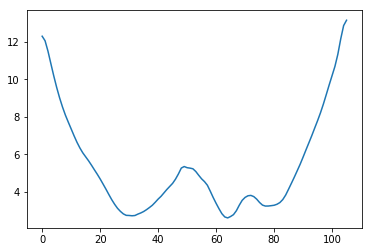

In [13]:
plt.plot(semor_profiles['walk'])

## Бег

In [14]:
run_df = pd.read_csv("data/run.csv", sep=",")
run_df.head()

,time,ax,ay,az,aT
0,0.002,-3.4192,-0.9210,-10.4057,10.992
1,0.007,-2.0544,-0.2453,-7.9017,8.168
2,0.015,-1.7284,0.5175,-3.4600,3.902
3,0.025,-1.6948,2.1708,2.2095,3.531
4,0.035,-2.7322,3.7436,6.5365,8.013


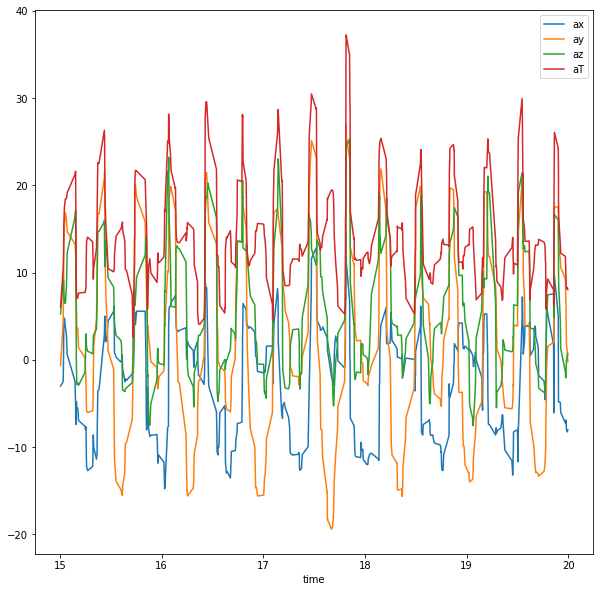

In [15]:
run_df[1500:2000].plot(x="time",figsize=(10, 10))

(array([ 1.,  2.,  5.,  0.,  6.,  4.,  0., 14., 21.,  0.,  8., 20., 13.,
         0., 10., 15.,  0.,  7.,  5.,  2.]),
 array([26. , 26.7, 27.4, 28.1, 28.8, 29.5, 30.2, 30.9, 31.6, 32.3, 33. ,
        33.7, 34.4, 35.1, 35.8, 36.5, 37.2, 37.9, 38.6, 39.3, 40. ]),
 <a list of 20 Patch objects>)

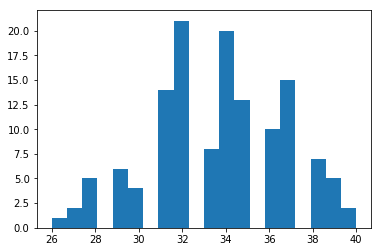

In [16]:
big_enough_segments = extract_segment_bounds(run_df, 'aT', 20, 25, 40)
# print(big_enough_segments)
plt.hist([s[1] - s[0] for s in big_enough_segments], bins=20)

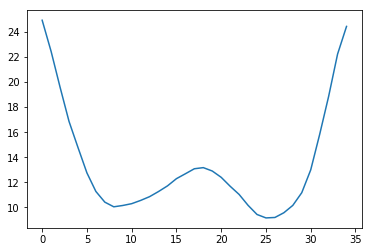

In [17]:
segments['run'] = [run_df.loc[first:second, 'aT'].values for first, second in big_enough_segments]
semor_profiles['run'], s = lapprox.segments.smooth.cubic_smooth(segments['run'], None)
plt.plot(semor_profiles['run'])

## Вверх по лестнице

In [18]:
up_df = pd.read_csv("data/going_up.csv", sep=",")
up_df.head()

,time,ax,ay,az,aT
0,0.004,-0.2690,-0.5730,1.2374,1.390
1,0.004,0.1720,-0.3095,1.1748,1.227
2,0.005,0.1555,-0.2983,1.1685,1.216
3,0.005,0.9333,-0.1316,0.8726,1.284
4,0.050,0.9043,-0.1224,0.8676,1.259


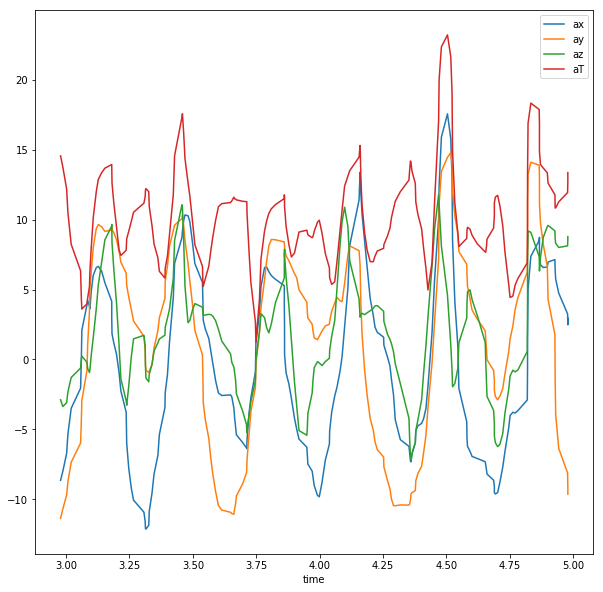

In [19]:
# up_df.loc[333:420, 'aT'].plot(x="time",figsize=(10, 10))
up_df[300:500].plot(x="time",figsize=(10, 10))

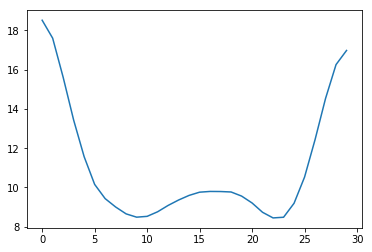

In [20]:
big_enough_segments = extract_segment_bounds(up_df, 'aT', 13,
                                             min_segment_size=20,
                                             max_segment_size=50,
                                             radius=10)
# plt.hist([s[1] - s[0] for s in big_enough_segments], bins=20)
# le = lapprox.misc.local_extrema.find_local_extrema(up_df['aT'].values, 15)
# up_df.index[le][up_df.index[le] > 300]
# print(big_enough_segments)
# plt.hist([s[1] - s[0] for s in big_enough_segments], bins=20)
# big_enough_segments

segments['up'] = [up_df.loc[first:second, 'aT'].values for first, second in big_enough_segments]
semor_profiles['up'], s = lapprox.segments.smooth.cubic_smooth(segments['up'], None)
plt.plot(semor_profiles['up'])

## Вниз по лестнице

In [21]:
down_df = pd.read_csv("data/going_down.csv", sep=",")
down_df.head()

,time,ax,ay,az,aT
0,0.002,-0.6411,0.1361,-6.1741,6.209
1,0.003,0.0001,0.3096,-6.0392,6.047
2,0.009,0.0322,0.8054,-4.3027,4.378
3,0.020,0.2623,0.8441,-1.8200,2.023
4,0.026,0.1156,0.5964,1.0434,1.207


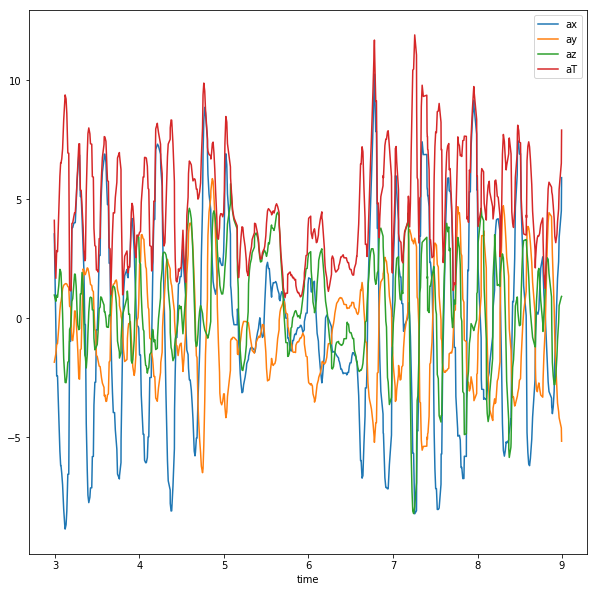

In [22]:
# up_df.loc[333:420, 'aT'].plot(x="time",figsize=(10, 10))
down_df[300:900].plot(x="time",figsize=(10, 10))

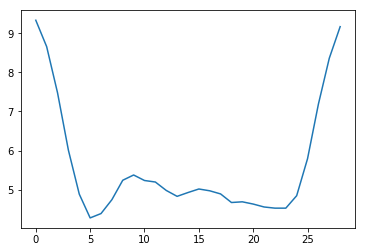

In [23]:
big_enough_segments = extract_segment_bounds(down_df, 'aT', 6,
                                             min_segment_size=20,
                                             max_segment_size=40,
                                             radius=10)

segments['down'] = [down_df.loc[first:second, 'aT'].values for first, second in big_enough_segments]
semor_profiles['down'], s = lapprox.segments.smooth.cubic_smooth(segments['down'], None)
plt.plot(semor_profiles['down'])

## Сохраняем результаты

In [24]:
# for key, semor_segment in semor_profiles.items():
#     with open("data/semor_{}_profile.pickle".format(key), "wb") as f:
#         pickle.dump(semor_segment, f)

# for key, segments_array in segments.items():
#     with open("data/segments_{}.pickle".format(key), "wb") as f:
#         pickle.dump(segments_array, f)

with open("data/semor_profiles.pickle", "wb") as f:
    pickle.dump(semor_profiles, f)

with open("data/segments.pickle", "wb") as f:
    pickle.dump(segments, f)  